In [103]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import itertools


In [84]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [85]:
#concatenate path to name of each file and store in array for reading in data
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)


In [86]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [241]:
#see all event ids
epoch.event_id

{'congruent': 133,
 'correct': 129,
 'f_baby': 155,
 'f_bell': 156,
 'f_bird': 157,
 'f_burp': 158,
 'f_dog': 159,
 'f_drum': 160,
 'f_knock': 161,
 'f_laugh': 162,
 'f_phone': 163,
 'f_train': 164,
 'f_water': 165,
 'flanker_stim_1': 1,
 'flanker_stim_10': 10,
 'flanker_stim_11': 11,
 'flanker_stim_12': 12,
 'flanker_stim_2': 2,
 'flanker_stim_3': 3,
 'flanker_stim_4': 4,
 'flanker_stim_5': 5,
 'flanker_stim_6': 6,
 'flanker_stim_7': 7,
 'flanker_stim_8': 8,
 'flanker_stim_9': 9,
 'incongruent': 134,
 'incorrect': 130,
 'left_button': 131,
 'right_button': 132,
 't_baby': 135,
 't_bell': 136,
 't_bird': 137,
 't_burp': 138,
 't_dog': 139,
 't_drum': 140,
 't_knock': 141,
 't_laugh': 142,
 't_phone': 143,
 't_train': 144,
 't_water': 145,
 'target_stim_13': 13,
 'target_stim_14': 14,
 'target_stim_15': 15,
 'target_stim_16': 16,
 'target_stim_17': 17,
 'target_stim_18': 18,
 'target_stim_19': 19,
 'target_stim_20': 20,
 'target_stim_21': 21,
 'target_stim_22': 22,
 'target_stim_23': 23

In [9]:
#first just classify a flanker and a target of same.
singleTargetFlanker = epoch['f_baby','t_baby']
singleTargetFlanker.event_id

{'f_baby': 155, 't_baby': 135}

In [12]:
dataX = singleTargetFlanker.get_data()
eventsY = singleTargetFlanker.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression())

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)

scoress = []
for train,test in cv.split(dataX,eventsY):
    clf.fit(dataX[train],eventsY[train])
    scoress.append(clf.score(dataX[test],eventsY[test]))

In [13]:
print("mean classification score", np.mean(scoress))

mean classification score 0.6262820512820514


In [87]:
''''f_baby': 155,
 'f_bell': 156,
 'f_bird': 157,
 'f_burp': 158,
 'f_dog': 159,
 'f_drum': 160,
 'f_knock': 161,
 'f_laugh': 162,
 'f_phone': 163,
 'f_train': 164,
 'f_water': 165,'''

#stores all flankers together

flankerEpochs = epoch['f_baby','f_bell','f_bird','f_burp','f_dog','f_drum','f_knock',
             'f_laugh','f_phone','f_train','f_water']

#store all targets together
targetEpochs = epoch['t_baby','t_bell','t_bird','t_burp','t_dog','t_drum','t_knock',
             't_laugh','t_phone','t_train','t_water']

#store all flankers and targets together

flankerTargetEpoch = epoch['f_baby','f_bell','f_bird','f_burp','f_dog','f_drum','f_knock',
             'f_laugh','f_phone','f_train','f_water','t_baby','t_bell','t_bird','t_burp','t_dog','t_drum','t_knock',
             't_laugh','t_phone','t_train','t_water']

test = flankerTargetEpoch

#set all flankers event ids to 0 and targets event ids to 1
for i in range(0,1280):
    if test.events[i][-1] in (155, 156, 157,158,159,160,161,162,163,164,165):
        test.events[i][-1] = 0
    elif test.events[i][-1] in (135, 136, 137,138,139,140,141,142,143,144,145):
        test.events[i][-1] = 1

#test.events


In [88]:
flankerTargetEpoch.events.shape[0]

1280

In [89]:
#Classify using LDA
dataXX = test.get_data()
eventsYY = test.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LDA())

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)
preds = np.empty(len(eventsYY))
scoresss = []
for train,test in cv.split(dataXX,eventsYY):
    clf.fit(dataXX[train],eventsYY[train])
    preds[test] = clf.predict(dataXX[test])
    scoresss.append(clf.score(dataXX[test],eventsYY[test]))

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

In [100]:
print("mean classification score", np.mean(scoresss))
report = classification_report(eventsYY, preds, target_names=target_names)
print(report)

mean classification score 0.76171875
             precision    recall  f1-score   support

    flanker       0.77      0.75      0.76       640
     target       0.76      0.77      0.76       640

avg / total       0.76      0.76      0.76      1280



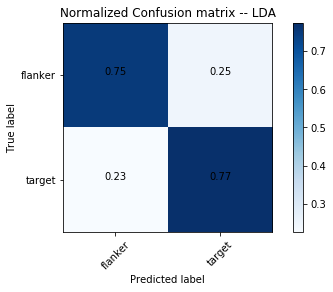

In [104]:
target_names = [ 'flanker', 'target']
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(eventsYY,preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- LDA')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

fmt = '.2f'
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j],fmt),
                 horizontalalignment="center",
                 color="black")
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
#classify 2 more files using LDA
classification_score = []
for i in range(0,2):
    epoch = mne.read_epochs(allFifFiles[i],preload=True)
    
    flankerTargetEpoch = epoch['f_baby','f_bell','f_bird','f_burp','f_dog','f_drum','f_knock',
             'f_laugh','f_phone','f_train','f_water','t_baby','t_bell','t_bird','t_burp','t_dog','t_drum','t_knock',
             't_laugh','t_phone','t_train','t_water']
    
    numOfEvents = flankerTargetEpoch.events.shape[0]
    test = flankerTargetEpoch
    
    for i in range(0,numOfEvents):
        if test.events[i][-1] in (155, 156, 157,158,159,160,161,162,163,164,165):
            test.events[i][-1] = 0
        elif test.events[i][-1] in (135, 136, 137,138,139,140,141,142,143,144,145):
            test.events[i][-1] = 1
    
    X = test.get_data()
    y=test.events[:,-1]
    
    clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LDA())

    #cross validation
    cv = StratifiedKFold(n_splits = 10, shuffle=True)

    scorz = []
    for train,test in cv.split(X,y):
        clf.fit(X[train],y[train])
        scorz.append(clf.score(X[test],y[test]))
        
    print("mean classification score", np.mean(scorz))    
    
    classification_score.append(np.mean(scorz))

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.75546875
Reading /Volumes/flash64/EpochedEEG/20140205_1114_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5379 matching events found
Applying baseline correction (mode: mean)
5379 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.73046875


In [57]:
print(classification_score)

[0.75546875, 0.73046875]


In [58]:
#classify more files
for i in range(3,10):
    epoch = mne.read_epochs(allFifFiles[i],preload=True)
    
    flankerTargetEpoch = epoch['f_baby','f_bell','f_bird','f_burp','f_dog','f_drum','f_knock',
             'f_laugh','f_phone','f_train','f_water','t_baby','t_bell','t_bird','t_burp','t_dog','t_drum','t_knock',
             't_laugh','t_phone','t_train','t_water']
    
    numOfEvents = flankerTargetEpoch.events.shape[0]
    test = flankerTargetEpoch
    
    for i in range(0,numOfEvents):
        if test.events[i][-1] in (155, 156, 157,158,159,160,161,162,163,164,165):
            test.events[i][-1] = 0
        elif test.events[i][-1] in (135, 136, 137,138,139,140,141,142,143,144,145):
            test.events[i][-1] = 1
    
    X = test.get_data()
    y=test.events[:,-1]
    
    clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LDA())

    #cross validation
    cv = StratifiedKFold(n_splits = 10, shuffle=True)

    scorz = []
    for train,test in cv.split(X,y):
        clf.fit(X[train],y[train])
        scorz.append(clf.score(X[test],y[test]))
        
    print("mean classification score", np.mean(scorz))    
    
    classification_score.append(np.mean(scorz))

Reading /Volumes/flash64/EpochedEEG/20140206_1029_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5384 matching events found
Applying baseline correction (mode: mean)
5384 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.596875
Reading /Volumes/flash64/EpochedEEG/20140206_1151_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5583 matching events found
Applying baseline correction (mode: mean)
5583 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.6346643412834654
Reading /Volumes/flash64/EpochedEEG/20140207_1146_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5398 matching events found
Applying baseline correction (mode: mean)
5398 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.6860251957059147
Reading /Volumes/flash64/EpochedEEG/20140207_1219_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5575 matching events found
Applying baseline correction (mode: mean)
5575 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.6696969696969697
Reading /Volumes/flash64/EpochedEEG/20140217_1136_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5584 matching events found
Applying baseline correction (mode: mean)
5584 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.7028278972935462
Reading /Volumes/flash64/EpochedEEG/20140217_1211_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5410 matching events found
Applying baseline correction (mode: mean)
5410 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.9875
Reading /Volumes/flash64/EpochedEEG/20140219_1046_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5433 matching events found
Applying baseline correction (mode: mean)
5433 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

mean classification score 0.73671875


In [62]:
print(classification_score)

[0.75546875, 0.73046875, 0.596875, 0.6346643412834654, 0.6860251957059147, 0.6696969696969697, 0.7028278972935462, 0.9875, 0.73671875]


Text(0.5,1,'LDA')

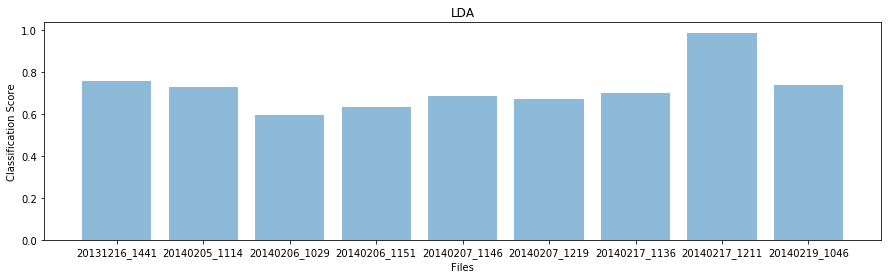

In [69]:
#plot bar graph of scores
plt.figure(figsize=(15,4))
subj = ['20131216_1441','20140205_1114','20140206_1029','20140206_1151','20140207_1146',
        '20140207_1219','20140217_1136','20140217_1211','20140219_1046']
pos = np.arange(len(subj))
plt.bar(pos, classification_score, align='center', alpha=0.5)
plt.xticks(pos, subj)
plt.xlabel("Files")
plt.ylabel('Classification Score')
plt.title('LDA')

In [80]:
#show stats of classification scores
mean = np.mean(classification_score)
max = np.max(classification_score)
min = np.min(classification_score)
median = np.median(classification_score)

print(f'mean classification score = {mean}')
print(f'max classification score = {max}')
print(f'min classification score = {min}')
print(f'median classification score = {median}')

mean classification score = 0.7222495171088773
max classification score = 0.9875
min classification score = 0.596875
median classification score = 0.7028278972935462


In [442]:
#testing shape of things
data = test.get_data()
print(data.shape)

events = flankerTargetEpoch.events[:,-1]
#events = events.reshape(events.shape[0],1)
print(events)
print(events.shape)

XX = data[:,-1] 
print(XX.shape)


#init pca and fit to data
pca = UnsupervisedSpatialFilter(PCA(), average=False)
pca_data = pca.fit_transform(data)

(1280, 129, 180)
[144 162 142 ... 161 142 161]
(1280,)
(1280, 180)


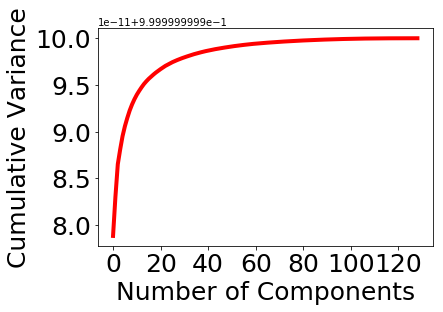

In [399]:
#plotting comp_variance to see which components are needed out of 128
comp_variance = np.cumsum(pca.estimator.explained_variance_ratio_)
plt.plot(comp_variance, linewidth = 4.0, color = 'R')
plt.xlabel('Number of Components', fontsize = 25)
plt.ylabel('Cumulative Variance', fontsize = 25);
plt.xticks(fontsize = 25);
plt.yticks(fontsize = 25);